In [1]:
import numpy as np
import os
import pandas as pd
import sys

# Config

In [2]:
HYPER_OPT = True 
HYPER_OPT_TIME = 1*60*60
USE_ORIGINAL_DATA = False 
SUBMIT_TO_KAGGLE = False
COMPUTE_NONLOG = False
USE_NONLOG = True

In [3]:
# Define the base directory (where the notebook is running)
base_dir = os.path.abspath(os.path.join(os.getcwd(), "..", ".."))
data_dir = os.path.join(base_dir, "data")
model_dir = os.path.join(base_dir, "models")
notebooks_dir = os.path.join(base_dir, "notebooks")
sys.path.append(base_dir)

# Data Extraction

In [4]:
from axyom_utilities.data_extraction import extract_data
from axyom_utilities.training import train_model_cv
from axyom_utilities.preprocessing import * 
from toolz import pipe
import joblib

# oof_log = pd.read_csv(os.path.join(notebooks_dir, "Catboost_nonlog\\oof_preds_log.csv"))
# oof_nonlog = pd.read_csv(os.path.join(notebooks_dir, "Catboost_nonlog\\oof_preds_nonlog.csv"))

# test_log = pd.read_csv(os.path.join(notebooks_dir, "Catboost_nonlog\\test_preds_log.csv"))
# test_nonlog = pd.read_csv(os.path.join(notebooks_dir, "Catboost_nonlog\\test_preds_nonlog.csv"))

# X_train["oof_nonlog"] = oof_nonlog + np.random.normal(0, 0.01, oof_log.shape) # noise
# X_test["oof_nonlog"] = test_nonlog + np.random.normal(0, 0.01, oof_log.shape)

# X_test["oof_log"] = test_log
# X_train["oof_log"] = oof_log

In [5]:
X_train, y_train, X_test, X_orig, y_orig = extract_data(data_dir, USE_ORIGINAL_DATA, log_transform=True)
y_train_nonlog = np.expm1(y_train)

if USE_NONLOG:
    if COMPUTE_NONLOG:
        nonlog_oof_preds, nonlog_test_preds = get_oof(X_train, y_train_nonlog, X_test)
    else:
        nonlog_oof_preds, nonlog_test_preds = joblib.load('nonlog_feature/cat_non_loged.pkl')
    
    X_train["nonlog"] = nonlog_oof_preds
    X_test["nonlog"] = nonlog_test_preds

# Data Cleaning

In [6]:

from axyom_utilities.preprocessing import freq_encode, preprocess_dates, clean_categorical, frequency_encode, reduce_memory_usage
from toolz import pipe

def feature_engineering(df):
    
    # df = freq_encode(df)
    
    df['MissingHealth'] = df['Health Score'].isna().astype(int)
    df['Claims v Duration'] = (df['Previous Claims'] / df['Insurance Duration']).replace([np.inf, -np.inf], np.nan)
    df['Health vs Claims'] = (df['Health Score'] / df['Previous Claims']).replace([np.inf, -np.inf], np.nan)
    
    def duplicate_int(col, df):
        df[col + ' Integer'] = df[col].apply(lambda x: int(x) if pd.notna(x) else x)
        #df[col] = df[col].fillna('None').astype('category')
        
        return df
    
    df = duplicate_int('Health Score', df)
    # df = duplicate_int('Credit Score', df)
    # df = duplicate_int('Previous Claims', df)
    # df = duplicate_int('Annual Income', df)
    
    df['contract length'] = pd.cut(
        df["Insurance Duration"].fillna(99),  
        bins=[-float('inf'), 1, 3, float('inf')],  
        labels=[0, 1, 2]
    ).astype(int)
    
    df['MissingValuesCount'] = df.isna().sum(axis=1)
    
    # df = freq_encode(df, 'Customer Feedback')
    # df = freq_encode(df, 'Marital Status')
    
    return df

#X_train = reduce_memory_usage(X_train)


preprocessor = lambda df: pipe(df,\
    preprocess_dates,
    clean_categorical,
    feature_engineering,  
    reduce_memory_usage
)

X_train = preprocessor(X_train)
X_test = preprocessor(X_test)
if USE_ORIGINAL_DATA:
    X_orig = preprocessor(X_orig)
    
frequency_encode(X_train, X_test, drop_org=False) # data leaking but acceptable in this context


(          Age  Gender  Annual Income Marital Status  Number of Dependents  \
 id                                                                          
 0        19.0  Female        10049.0        Married                   1.0   
 1        39.0  Female        31678.0       Divorced                   3.0   
 2        23.0    Male        25602.0       Divorced                   3.0   
 3        21.0    Male       141855.0        Married                   2.0   
 4        21.0    Male        39651.0         Single                   1.0   
 ...       ...     ...            ...            ...                   ...   
 1199995  36.0  Female        27316.0        Married                   0.0   
 1199996  54.0    Male        35786.0       Divorced                   NaN   
 1199997  19.0    Male        51884.0       Divorced                   0.0   
 1199998  55.0    Male            NaN         Single                   1.0   
 1199999  21.0  Female            NaN       Divorced            

# HyperOpt

In [7]:
X_train.shape

(1200000, 44)

[I 2024-12-27 11:16:46,623] Using an existing study with name 'XGBOOST_v2' instead of creating a new one.


Training fold 1...
Fold 1 RMSE: 1.0325
Training fold 2...
Fold 2 RMSE: 1.0315
Training fold 3...
Fold 3 RMSE: 1.0309
Training fold 4...
Fold 4 RMSE: 1.0329
Training fold 5...


[I 2024-12-27 11:17:31,322] Trial 13 finished with value: 1.0319132344868938 and parameters: {'learning_rate': 0.027419180587908182, 'max_depth': 7, 'min_child_weight': 0.7731066398121926, 'subsample': 0.7020543458800385, 'colsample_bytree': 0.8247840482630118, 'gamma': 2.879789937206117, 'lambda': 8.692509389521172, 'alpha': 0.00124083513847564}. Best is trial 9 with value: 1.031174180038696.


Fold 5 RMSE: 1.0318
Mean CV RMSE: 1.0319 ± 0.0007
Training fold 1...
Fold 1 RMSE: 1.0322
Training fold 2...
Fold 2 RMSE: 1.0315
Training fold 3...
Fold 3 RMSE: 1.0306
Training fold 4...
Fold 4 RMSE: 1.0326
Training fold 5...


[I 2024-12-27 11:26:29,928] Trial 14 finished with value: 1.0317198416701028 and parameters: {'learning_rate': 0.003327469086720437, 'max_depth': 12, 'min_child_weight': 0.018801001031756307, 'subsample': 0.7626718703385482, 'colsample_bytree': 0.9961832759562471, 'gamma': 3.8238796333932177, 'lambda': 0.0019565733215838256, 'alpha': 0.05993344620970629}. Best is trial 9 with value: 1.031174180038696.


Fold 5 RMSE: 1.0317
Mean CV RMSE: 1.0317 ± 0.0007
Training fold 1...
Fold 1 RMSE: 1.0321
Training fold 2...
Fold 2 RMSE: 1.0312
Training fold 3...
Fold 3 RMSE: 1.0304
Training fold 4...
Fold 4 RMSE: 1.0326
Training fold 5...


[I 2024-12-27 11:27:43,502] Trial 15 finished with value: 1.0315463065214434 and parameters: {'learning_rate': 0.012996346568521144, 'max_depth': 8, 'min_child_weight': 7.104456257359448, 'subsample': 0.6231553992772758, 'colsample_bytree': 0.7840323997977896, 'gamma': 4.974574933858394, 'lambda': 0.47077301241934366, 'alpha': 0.0052666072876910745}. Best is trial 9 with value: 1.031174180038696.


Fold 5 RMSE: 1.0314
Mean CV RMSE: 1.0315 ± 0.0008
Training fold 1...


[I 2024-12-27 11:28:05,719] Trial 16 pruned. 


Training fold 1...
Fold 1 RMSE: 1.0319
Training fold 2...
Fold 2 RMSE: 1.0312
Training fold 3...
Fold 3 RMSE: 1.0303
Training fold 4...
Fold 4 RMSE: 1.0324
Training fold 5...


[I 2024-12-27 11:30:02,739] Trial 17 finished with value: 1.0314057049735486 and parameters: {'learning_rate': 0.008280381209067418, 'max_depth': 8, 'min_child_weight': 0.2807478374978463, 'subsample': 0.7802652358724385, 'colsample_bytree': 0.66994345592663, 'gamma': 4.089036259481665, 'lambda': 0.003660767638266061, 'alpha': 0.14492636212600937}. Best is trial 9 with value: 1.031174180038696.


Fold 5 RMSE: 1.0312
Mean CV RMSE: 1.0314 ± 0.0007
Training fold 1...
Fold 1 RMSE: 1.0318
Training fold 2...
Fold 2 RMSE: 1.0312
Training fold 3...
Fold 3 RMSE: 1.0301
Training fold 4...
Fold 4 RMSE: 1.0322
Training fold 5...
Fold 5 RMSE: 1.0312
Mean CV RMSE: 1.0313 ± 0.0007


[I 2024-12-27 11:42:45,552] Trial 18 finished with value: 1.0313240971140067 and parameters: {'learning_rate': 0.002087653379756953, 'max_depth': 11, 'min_child_weight': 2.4145724733674285, 'subsample': 0.803966431494185, 'colsample_bytree': 0.6609238919011824, 'gamma': 4.36347044648731, 'lambda': 0.19097927304242837, 'alpha': 0.22190050431878136}. Best is trial 9 with value: 1.031174180038696.


Training fold 1...
Fold 1 RMSE: 1.0317
Training fold 2...
Fold 2 RMSE: 1.0311
Training fold 3...
Fold 3 RMSE: 1.0301
Training fold 4...
Fold 4 RMSE: 1.0322
Training fold 5...
Fold 5 RMSE: 1.0312
Mean CV RMSE: 1.0313 ± 0.0007


[I 2024-12-27 11:55:01,281] Trial 19 finished with value: 1.0312886477500205 and parameters: {'learning_rate': 0.0019780433057020185, 'max_depth': 11, 'min_child_weight': 3.625350802585087, 'subsample': 0.9103094273212441, 'colsample_bytree': 0.6857537037260059, 'gamma': 4.546123897149356, 'lambda': 0.27125925467121725, 'alpha': 0.24380473037011463}. Best is trial 9 with value: 1.031174180038696.


Training fold 1...
Fold 1 RMSE: 1.0317
Training fold 2...
Fold 2 RMSE: 1.0311
Training fold 3...
Fold 3 RMSE: 1.0301
Training fold 4...
Fold 4 RMSE: 1.0322
Training fold 5...


[I 2024-12-27 12:03:06,940] Trial 20 finished with value: 1.0312506316518164 and parameters: {'learning_rate': 0.002670769300447097, 'max_depth': 11, 'min_child_weight': 46.45847909754045, 'subsample': 0.910175791269019, 'colsample_bytree': 0.9127249864153708, 'gamma': 3.303846259322972, 'lambda': 2.221272671818476, 'alpha': 9.147058505972058}. Best is trial 9 with value: 1.031174180038696.


Fold 5 RMSE: 1.0312
Mean CV RMSE: 1.0313 ± 0.0007
Training fold 1...
Fold 1 RMSE: 1.0317
Training fold 2...
Fold 2 RMSE: 1.0311
Training fold 3...
Fold 3 RMSE: 1.0301
Training fold 4...
Fold 4 RMSE: 1.0322
Training fold 5...


[I 2024-12-27 12:10:29,432] Trial 21 finished with value: 1.0312305584174442 and parameters: {'learning_rate': 0.0029267643614721626, 'max_depth': 11, 'min_child_weight': 36.013366085510334, 'subsample': 0.9184999749772507, 'colsample_bytree': 0.8941099338904073, 'gamma': 3.4003256760629403, 'lambda': 2.209507396301271, 'alpha': 8.997863596875836}. Best is trial 9 with value: 1.031174180038696.


Fold 5 RMSE: 1.0311
Mean CV RMSE: 1.0312 ± 0.0007
Training fold 1...
Fold 1 RMSE: 1.0319
Training fold 2...
Fold 2 RMSE: 1.0312
Training fold 3...
Fold 3 RMSE: 1.0303
Training fold 4...
Fold 4 RMSE: 1.0323
Training fold 5...
Fold 5 RMSE: 1.0314
Mean CV RMSE: 1.0314 ± 0.0007


[I 2024-12-27 12:26:51,806] Trial 22 finished with value: 1.0314261713607822 and parameters: {'learning_rate': 0.0010543751253327877, 'max_depth': 11, 'min_child_weight': 43.76400880146101, 'subsample': 0.9956203110289197, 'colsample_bytree': 0.9010412063438531, 'gamma': 3.115872538410822, 'lambda': 2.0922154352918643, 'alpha': 8.806986030205021}. Best is trial 9 with value: 1.031174180038696.


Best Trial:  {'learning_rate': 0.0018074015405110902, 'max_depth': 10, 'min_child_weight': 35.82538209022429, 'subsample': 0.8430826729425029, 'colsample_bytree': 0.8317303646698226, 'gamma': 4.465216932504686, 'lambda': 7.090856965711639, 'alpha': 0.00614046006689163}
Best Score:  1.031174180038696


c:\Users\Axyom\Kaggle\PG S4e12 - Regression Insurance\axyom_utilities\hyperparameter_tuning.py:59: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  plot_optimization_history(self.study)


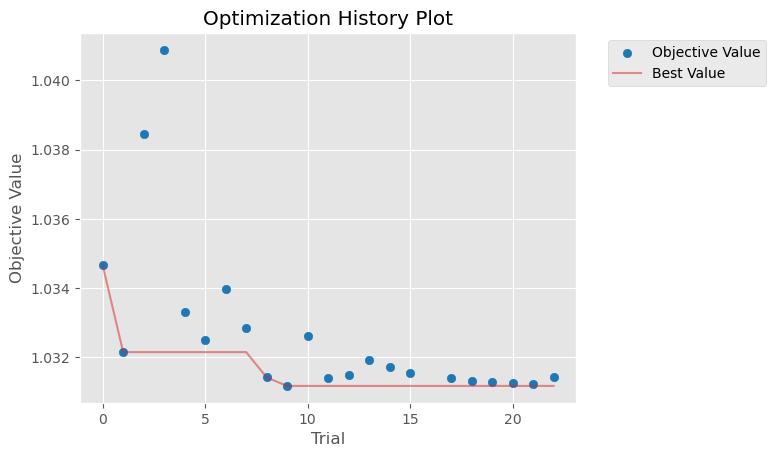

c:\Users\Axyom\Kaggle\PG S4e12 - Regression Insurance\axyom_utilities\hyperparameter_tuning.py:62: ExperimentalWarning: plot_param_importances is experimental (supported from v2.2.0). The interface can change in the future.
  plot_param_importances(self.study)


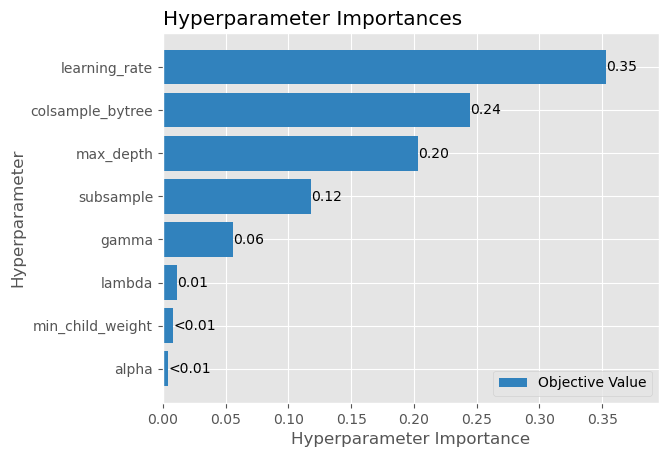

c:\Users\Axyom\Kaggle\PG S4e12 - Regression Insurance\axyom_utilities\hyperparameter_tuning.py:65: ExperimentalWarning: plot_slice is experimental (supported from v2.2.0). The interface can change in the future.
  plot_slice(self.study)


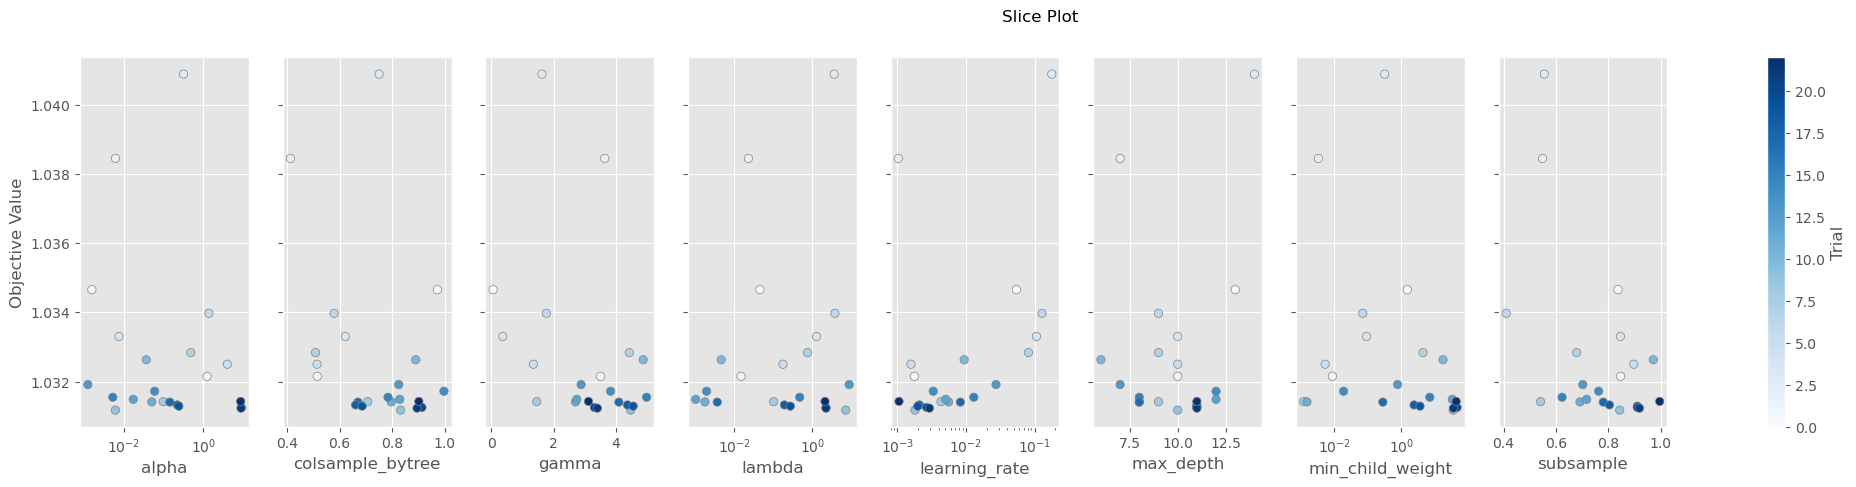

In [8]:
from axyom_utilities.hyperparameter_tuning import XGBoostTuner

if HYPER_OPT:
    tuner = XGBoostTuner(X_train, y_train, HYPER_OPT_TIME, study_name="XGBOOST_v2")
    best_params = tuner.tune()
    tuner.plot()
else:
    best_params = {
        "iterations":3000,
        "learning_rate":0.05,
        "depth":6,
        "eval_metric":"RMSE",
        "random_seed":42,
        "verbose":200,
        "task_type":'GPU',
        "l2_leaf_reg" :0.7,
    }

In [9]:
best_params

{'n_estimators': 4000,
 'objective': 'reg:squarederror',
 'tree_method': 'gpu_hist',
 'verbosity': 0,
 'enable_categorical': True,
 'learning_rate': 0.0018074015405110902,
 'max_depth': 10,
 'min_child_weight': 35.82538209022429,
 'subsample': 0.8430826729425029,
 'colsample_bytree': 0.8317303646698226,
 'gamma': 4.465216932504686,
 'lambda': 7.090856965711639,
 'alpha': 0.00614046006689163,
 'n_iterators': 3393}

In [10]:
best_params["n_iterators"] = 10000

# Model Training

In [11]:
import json
from axyom_utilities.wrappers import XGBRegressorWrapper

model = XGBRegressorWrapper(**best_params)

# Use the train_model function to train and evaluate the model
results = train_model_cv(
    model=model,
    X_train=X_train,
    y_train=y_train,
    X_test=X_test,
    X_orig=X_orig,
    early_stopping_rounds=100,
    cv_splits=5
)

Training fold 1...
Fold 1 RMSE: 1.0316
Training fold 2...
Fold 2 RMSE: 1.0310
Training fold 3...
Fold 3 RMSE: 1.0300
Training fold 4...
Fold 4 RMSE: 1.0322
Training fold 5...
Fold 5 RMSE: 1.0311
Mean CV RMSE: 1.0312 ± 0.0007


In [12]:
# models = results['models']

# # Get feature importance
# feature_importances = models[3].catboost_model_.get_feature_importance(type='PredictionValuesChange')

# # Map to feature names
# feature_importance_df = pd.DataFrame({
#     'Feature': X_train.columns,
#     'Importance': feature_importances
# }).sort_values(by='Importance', ascending=False)

# print(feature_importance_df)

In [13]:
mean_score = np.mean(results["cv_scores"])
std_score = np.std(results["cv_scores"])

# Saving

In [14]:
import json
from pathlib import Path

results_dir = Path(f"{mean_score:.4f}+-{std_score:.4f}")
os.makedirs(results_dir, exist_ok=True)

# Save OOF predictions as a CSV file
oof_preds_df = pd.DataFrame({"oof_preds": results["oof_preds"]})
oof_preds_df.to_csv(results_dir/"oof_preds.csv", index=False)

test_preds_df = pd.DataFrame({"test_preds": results["test_preds"]})
test_preds_df.to_csv(results_dir/"test_preds.csv", index=False)

with open(results_dir/"best_params", "w") as f:
    json.dump(best_params, f, indent=4)

#joblib.dump(results["models"], "models.pkl")

# Submission

In [15]:
y_pred = np.expm1(results['test_preds'])

submission = pd.DataFrame({
    'id': X_test.index,  
    'Premium Amount': y_pred
})

FILE_PATH = os.path.join(results_dir, f"XGBoost_v2_{mean_score:.4f}+-{std_score:.4f}.csv")

submission.to_csv(FILE_PATH, index=False)

In [16]:
if False: 
    # Define your message and file paths
    COMP_NAME = "playground-series-s4e12"

    SUBMIT_MESSAGE = "{mean_score:.4f}+-{std_score:.4f}"

    # Submit to Kaggle
    os.system(f'kaggle competitions submit -c {COMP_NAME} -f {FILE_PATH} -m "{SUBMIT_MESSAGE}"')